In [70]:
SEED=3012024

DEVICE = "cpu" # MacM2 processor is mps ,if CUDA is cuda

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

torch.manual_seed(SEED)

### VAEs 

1. Bishop 10.4)

$p(X)$ is a fixed distribution and we approximate is using $q(X)=\mathcal{N}(x|\mu,\Sigma)$. 

The KL divergence $KL(p||q)$ for the Gaussian $q(X)$ is then 
$KL(p||q)=-\int_{-\infty}^{\infty}p(X)\log(\frac{p(X)}{q(X)})dx\Leftrightarrow -\int_{-\infty}^{\infty} p(X)(\log(p(X))-\log(\mathcal{N}(x|\,u,\Sigma)))dx$.

We introduce the latent $z$:
$-\int_{-\infty}^{\infty} \frac{p(X,z)}{p(z|x)}(\log(\frac{p(X,z)}{p(z|X)})-\log(q(X)))dx$.


Minimizing the KLD leads to $\mu$ given by the expectation of $X$ under $p(X)$ and $\Sigma$ by the covariance, since
for the mean $\mu$:

$\frac{\partial}{\partial_\mu} q(X)=\Sigma^{-1}(X-\mu)q(X)=\Sigma^{-1}(X-\mu)\mathcal{N}(x|\mu,\Sigma)=\int p(X)\Sigma^{-1}(X-\mu)dx = \int p(X) \Sigma^{-1} \mu - \Sigma^{-1} X dx = \Sigma^{-1} \mu - \Sigma^{-1} E[X] = 0 \Leftrightarrow \mu = E[X]$.

With $\mu = E[X]$:

$\frac{d}{d\Sigma}KL(p||q) = 0 \Leftrightarrow \Sigma = E[XX^T] - \mu \mu^T = E[XX^T] - E[X]E[X]^T = cov(X)$

Note that many intermediate steps are left out. And a lot of matrix calculations are needed.

In [71]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [72]:
## using the provided resource as base architecture
class HierarchicalVAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        # assert len(hidden_dims) == 8, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.enc_h1 = nn.Linear(hidden_dims[2], hidden_dims[3])
        # define hidden and latent
        self.enc_mu1 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma1 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_mu2 = nn.Linear(hidden_dims[3], hidden_dims[4])
        self.enc_sigma2 = nn.Linear(hidden_dims[3], hidden_dims[4])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[-3], hidden_dims[-2])
        # self.dec_h1 = nn.Linear(hidden_dims[-3], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode1(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))

        mu = self.enc_mu1(h2)
        sigma = self.enc_sigma1(h2)

        return mu, sigma

    def encode2(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h3 = F.relu(self.enc_h1(z))

        mu = self.enc_mu2(h3)
        sigma = self.enc_sigma2(h3)

        return mu, sigma

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        # h4 = F.relu(self.dec_h1(h3))
        h5 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h5))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu1, logvar1 = self.encode1(x.view(-1, self.data_dim))
        z = self.reparameterize(mu1, logvar1)
        mu2, logvar2 = self.encode2(z)
        z = self.reparameterize(mu2, logvar2)

        return self.decode(z), mu1, logvar1, mu2, logvar2

In [73]:
def train(model: VAE, loss, optimizer, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, *params = model(x)
        loss_val, ce, kld = loss(recon_batch, x, *params)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [74]:
def test(model: VAE, loss, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, *params = model(x)
            test_loss_val, *rest = loss(recon_batch, x, *params)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [75]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [76]:
## load the MNIST data we've used previously
## use torch dataloader object for the heavy lifting

mnist_train = np.loadtxt("./data/mnist_train.csv", delimiter=",", dtype=np.float32)
mnist_test = np.loadtxt("./data/mnist_test.csv", delimiter=",", dtype=np.float32)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255 # NOTE: don't forget to standardize

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [77]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
def logC(x, eps=1e-5):
    x = torch.clamp(x, eps, 1-eps)
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    # How I understand it should be
    far_values = torch.log((2. * torch.arctanh(1. - 2.*far)).div(1. - 2.*far))
    close_values = torch.log(2.*torch.ones(close.shape[0]))
    # Code found on https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/utils.py (Using second-order taylor approximation of C)
    # far_values = torch.log((torch.log(1. - far) - torch.log(far)).div(1. - 2. * far))
    # close_values = torch.log(torch.tensor(2.)) + torch.log(1. + torch.pow(1. - 2. * close, 2)/3.)
    return far_values.sum() + close_values.sum()

def log_beta_dist(X, Y):
    y_mean = Y.mean(axis=1)
    y_var  = Y.var(axis=1)

    a = y_mean * (y_mean * (1 - y_mean) / y_var - 1)
    b = (1 - y_mean) * (y_mean * (1 - y_mean) / y_var - 1)

    result = 0
    for batch_idx in range(X.shape[0]):
        result += (torch.lgamma(a[batch_idx] + b[batch_idx]) - torch.lgamma(a[batch_idx]) - torch.lgamma(b[batch_idx]) + (a[batch_idx] - 1) * torch.log(X[batch_idx]) + (b[batch_idx] - 1) * torch.log(1 - X[batch_idx])).sum()
    return result


def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO

def loss_cb_vae(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOGC = -logC(recon_x)
    return BCE + LOGC + KLD, BCE, KLD # = -ELBO

def loss_beta_dist_vae(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOG_BETA_DIST = log_beta_dist(recon_x, x.view(-1, 784))
    return LOG_BETA_DIST + BCE + KLD, BCE, KLD # = -ELBO
    
def hierarchical_loss(recon_x: torch.Tensor, x: torch.Tensor, mu1: torch.Tensor, logvar1: torch.Tensor, mu2: torch.Tensor, logvar2: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD1 = -1/2 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())
    KLD2 = -1/2 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())
    KLD = KLD1 + KLD2

    return BCE + KLD, BCE, KLD # = -ELBO


def train_test_loss(model, loss, optimizer):
    train_loss_vals_total = []
    test_loss_vals_total = []
    for e in range(1, EPOCHS+1):
        train_loss_vals = train(model, loss, optimizer, e, train_loader)
        test_loss_vals = test(model, loss, e, test_loader)
        train_loss_vals_total.append(train_loss_vals)
        test_loss_vals_total.append(test_loss_vals)

    return train_loss_vals_total, test_loss_vals_total

# Bernoulli VAE
model_vae = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)
train_loss_vae, test_loss_vae = train_test_loss(model_vae, loss, optimizer)
# CB VAE
model_cbvae = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_cbvae.parameters(), lr=1e-3)
train_loss_cbvae, test_loss_cbvae = train_test_loss(model_cbvae, loss_cb_vae, optimizer)
# beta VAE
model_beta_dist_vae = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_beta_dist_vae.parameters(), lr=1e-3)
train_loss_beta_vae, test_loss_beta_vae = train_test_loss(model_beta_dist_vae, loss_beta_dist_vae, optimizer)
# hierarchical VAE
model_hierarchical_vae = HierarchicalVAE(hidden_dims=[512, 256, 128, 32, 2, 256, 512])
optimizer = optim.Adam(model_hierarchical_vae.parameters(), lr=1e-3)
train_loss_hierarchical_vae, test_loss_hierarchical_vae = train_test_loss(model_hierarchical_vae, hierarchical_loss, optimizer)

Train epoch=1 [0/60000]	 loss=545.4998168945312
BCE=69782.484375 KLD=41.49367141723633
Train epoch=1 [3200/60000]	 loss=229.54690551757812
BCE=28894.05078125 KLD=487.953369140625
Train epoch=1 [6400/60000]	 loss=214.46768188476562
BCE=27035.15625 KLD=416.70794677734375
Train epoch=1 [9600/60000]	 loss=205.34324645996094
BCE=25943.8515625 KLD=340.0835266113281
Train epoch=1 [12800/60000]	 loss=208.10723876953125
BCE=26330.501953125 KLD=307.2247314453125
Train epoch=1 [16000/60000]	 loss=205.365478515625
BCE=25861.771484375 KLD=425.0087890625
Train epoch=1 [19200/60000]	 loss=200.02427673339844
BCE=25042.89453125 KLD=560.2134399414062
Train epoch=1 [22400/60000]	 loss=199.21792602539062
BCE=24886.6796875 KLD=613.2139892578125
Train epoch=1 [25600/60000]	 loss=199.57188415527344
BCE=24974.74609375 KLD=570.455810546875
Train epoch=1 [28800/60000]	 loss=194.061767578125
BCE=24048.57421875 KLD=791.3329467773438
Train epoch=1 [32000/60000]	 loss=196.9707794189453
BCE=24360.912109375 KLD=851.3

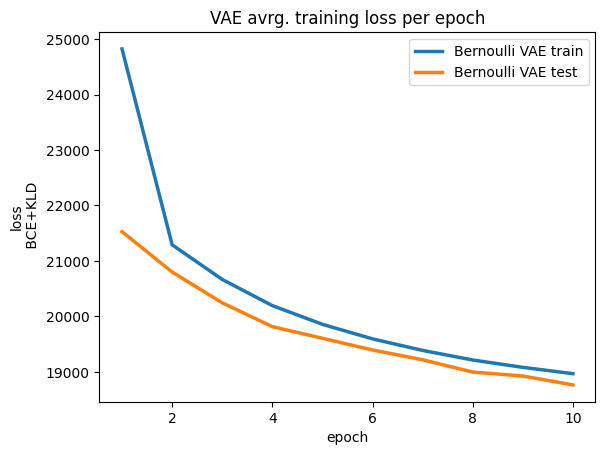

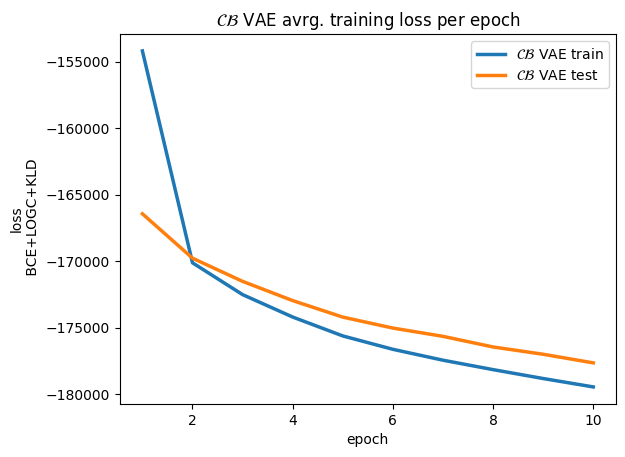

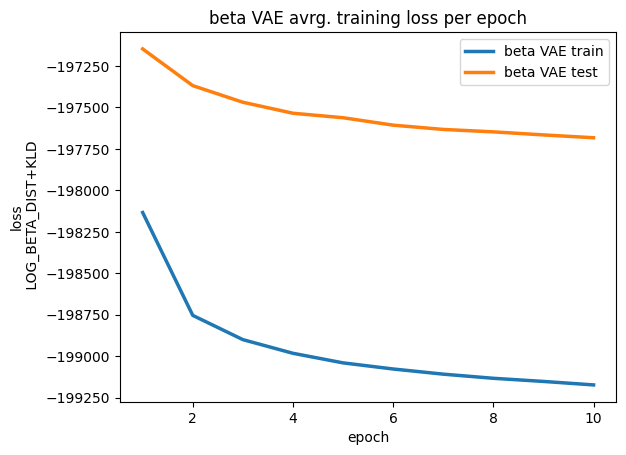

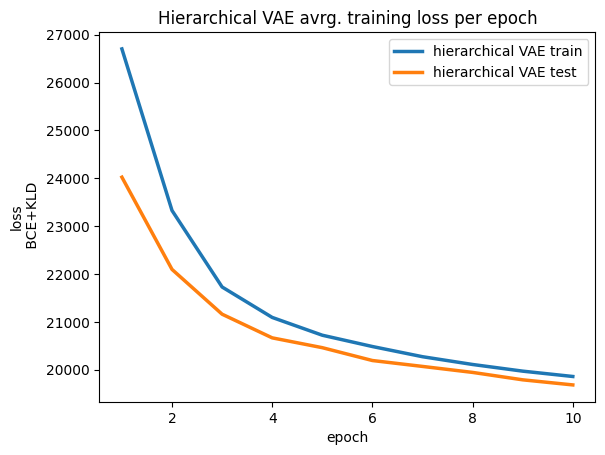

In [78]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vae], lw=2.5, label="Bernoulli VAE train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vae], lw=2.5, label="Bernoulli VAE test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_cbvae], lw=2.5, label="$\mathcal{CB}$ VAE train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_cbvae], lw=2.5, label="$\mathcal{CB}$ VAE test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+LOGC+KLD")
# plt.yscale("log")
plt.title("$\mathcal{CB}$ VAE avrg. training loss per epoch")
plt.legend()
plt.show()

plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_beta_vae], lw=2.5, label="beta VAE train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_beta_vae], lw=2.5, label="beta VAE test")
plt.xlabel("epoch")
plt.ylabel("loss\n LOG_BETA_DIST+KLD")
# plt.yscale("log")
plt.title("beta VAE avrg. training loss per epoch")
plt.legend()
plt.show()

plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_hierarchical_vae], lw=2.5, label="hierarchical VAE train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_hierarchical_vae], lw=2.5, label="hierarchical VAE test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("Hierarchical VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [79]:
# encode entries
latent_coordinates_vae = []
latent_coordinates_cbvae = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates_vae.append(model_vae.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
    latent_coordinates_cbvae.append(model_cbvae.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates_vae = np.array(latent_coordinates_vae)
latent_coordinates_cbvae = np.array(latent_coordinates_cbvae)


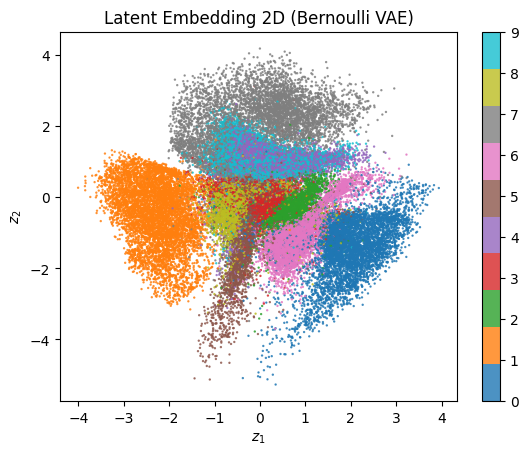

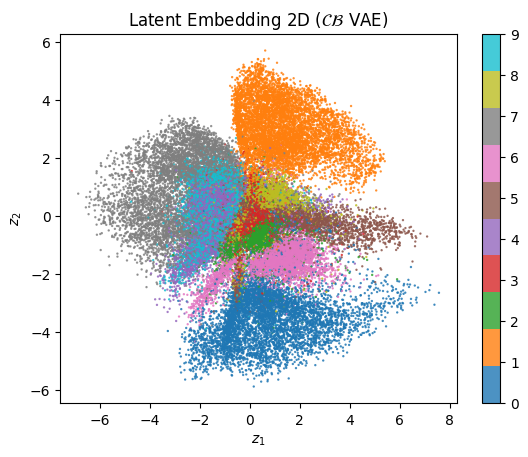

In [80]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates_vae[:,0], latent_coordinates_vae[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D (Bernoulli VAE)")
plt.show()

plt.scatter(latent_coordinates_cbvae[:,0], latent_coordinates_cbvae[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D ($\mathcal{CB}$ VAE)")
plt.show()

Compared to the PPCA we obtain better spatial separation. 
Numbers of the same label are grouped together in coherent clusters.


The architecture is modified by introducing another hidden layer in the encoder and decoder.

### Visualization by Gauss CDF

In [81]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

torch.Size([144, 2])

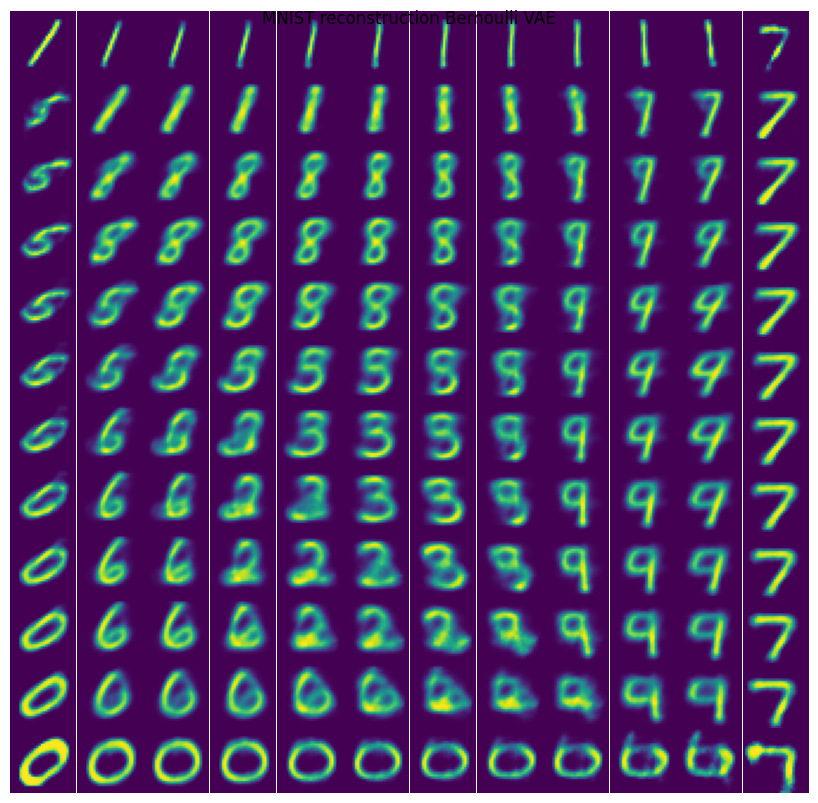

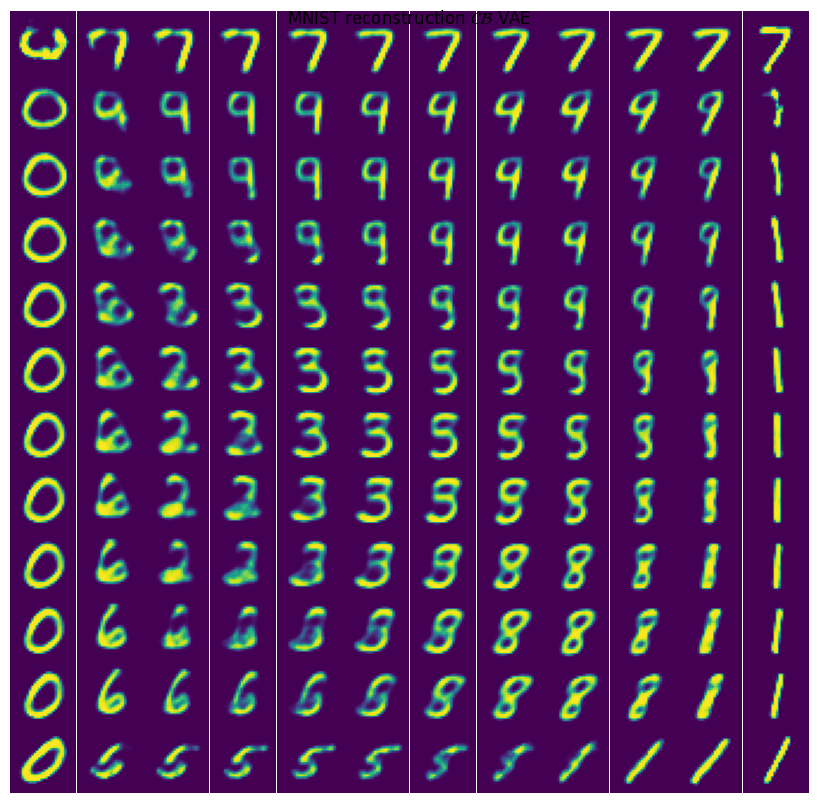

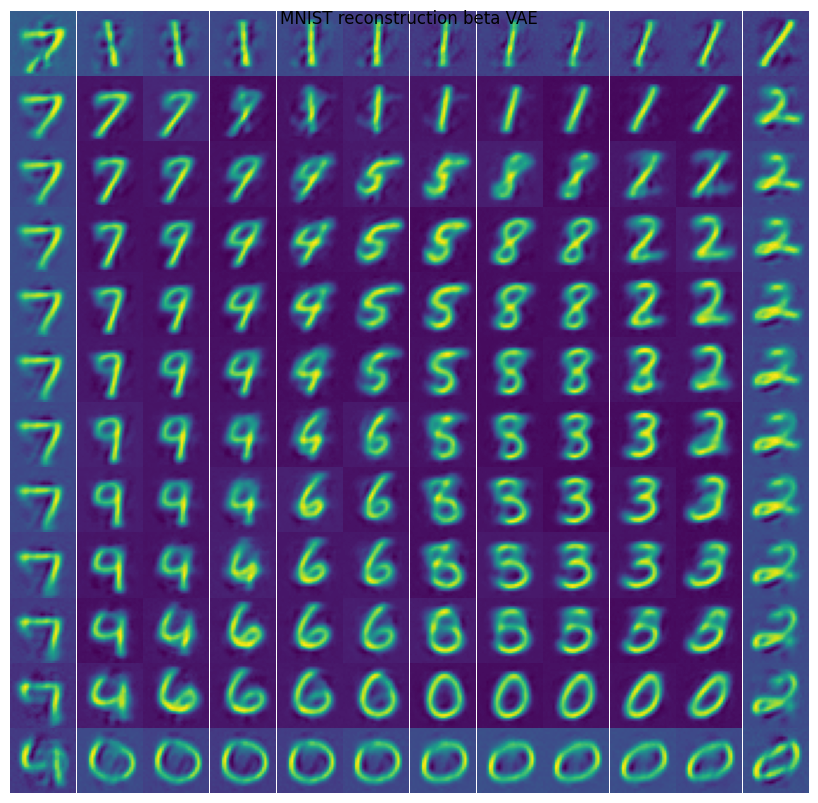

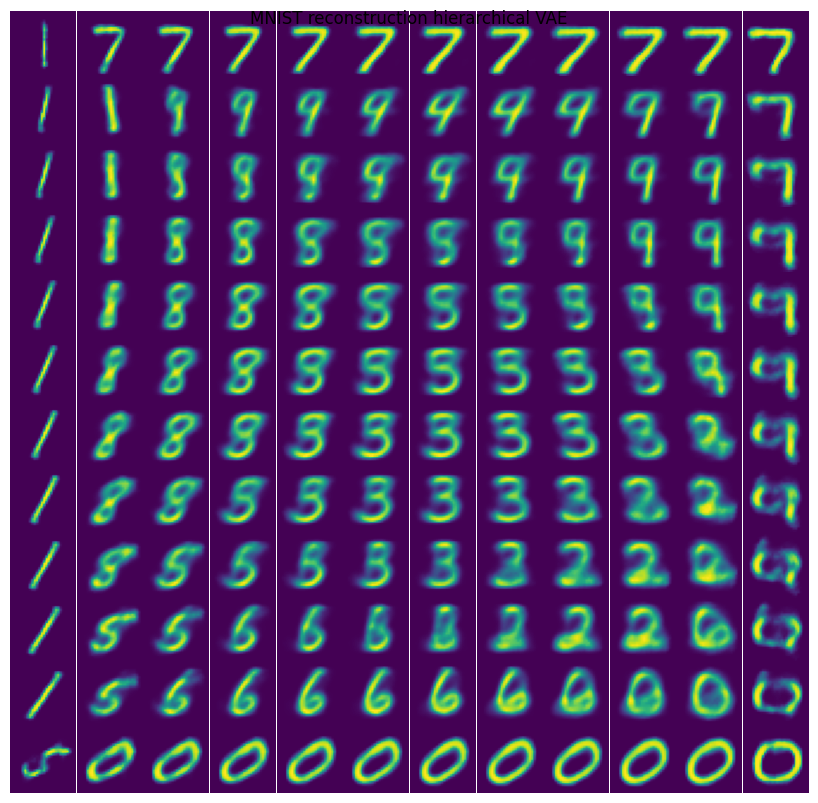

In [82]:

def plot_visualization(model, name):
    fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

    k = 0
    for i in range(n_cols):
        for j in range(n_cols):
            _zz = zz_gauss_cdf_vals[k]
            reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
            img = reconstruction.reshape((28,28))
            ax[i, j].imshow(img)
            ax[i, j].set_axis_off()
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            k += 1
    plt.suptitle(f"MNIST reconstruction {name}")
    plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
    plt.show()

plot_visualization(model_vae, "Bernoulli VAE")
plot_visualization(model_cbvae, "$\mathcal{CB}$ VAE")
plot_visualization(model_beta_dist_vae, "beta VAE")
plot_visualization(model_hierarchical_vae, "hierarchical VAE")
